In [ ]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import opty
from opty.utils import create_objective_function, parse_free
from opty.direct_collocation import Problem
me.init_vprinting()
import matplotlib.pyplot as plt

The example below is from [**Davide Sandonà**](https://github.com/Davide-sd).

I only made a few insignificant changes.

## Schematic

Taken from [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0005109801001455)

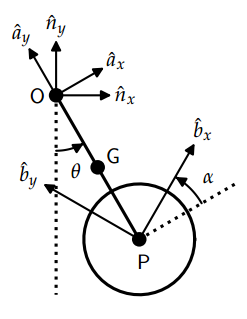

Let's consider an inverted pendulum, with a wheel and a motor connected to its free end. The motor applies the torque $T_{w}(t)$ on the wheel.

The pendulum starts at some configuration:
$$
\begin{aligned}
\theta(t=0) &= \theta_{0} \\
\alpha(t=0) &= 0 \\
\dot{\theta}(t=0) &= \dot{\alpha}(t=0) = 0
\end{aligned}
$$

Swing the pendulum from $\theta_{0}$ to standing up using minimal input energy with a bounded $T_{w}(t)$ magnitude.

For simplicity, I'm not going to consider friction on the joints, nor disturbance torques. Also, the numerical quantities used in this example are "random", they are not taken from the paper.

## Equation of Motion

In [ ]:
alpha, theta = me.dynamicsymbols("alpha, theta")
alphad, thetad = me.dynamicsymbols("alpha, theta", 1)
u1, u2 = me.dynamicsymbols("u1, u2")
Tw = me.dynamicsymbols("T_w") # torque applied by the motor to the wheel

r, L, g, m_rod, m_disk = sm.symbols("r, L, g, m_r, m_d")

t = me.dynamicsymbols._t

N, N_aux, A, B = sm.symbols("N, N_aux, A, B", cls=me.ReferenceFrame)
auxx, auxy, auxt, fx, fy, tz = me.dynamicsymbols("auxx, auxy, auxt, fx, fy, tz")

# N_aux is needed to get the reaction torque at O (should be zero)
N_aux.orient_axis(N, N.z, 0)
N_aux.set_ang_vel(N, auxt*N.z)

A.orient_axis(N_aux, N.z, theta)
A.set_ang_vel(N_aux, thetad*N.z)

B.orient_axis(A, N.z, alpha)
B.set_ang_vel(A, alphad*N.z)

inertia_rod = me.inertia(A, 0, 0, 1/12*m_rod*L**2)
inertia_disk = me.inertia(B, 0, 0, m_disk*r**2/2)

# O: pin joint of the pendulum
# G: center of mass of the rod
# P: pin joint of the wheel
O, P, G = sm.symbols("O, P, G", cls=me.Point)
G.set_pos(O, -L/2 * A.y) # assume center of mass of rod is located here
P.set_pos(O, -L * A.y)

O.set_vel(N, auxx*N.x + auxy*N.y)

G.v2pt_theory(O, N, A)
P.v2pt_theory(O, N, A)

bodies = [
    me.RigidBody("rod", G, A, m_rod, (inertia_rod, G)),
    me.RigidBody("disk", P, B, m_disk, (inertia_disk, P))
]

loads = [
    (G, -m_rod * g * N.y),
    (P, -m_disk * g * N.y),
    (O, fx*N.x + fy*N.y),
    (B, Tw * N.z),
    (A, -Tw * N.z),  # do not forget to add the reaction torque!
    (N_aux, tz * N.z),
]

kd_eqs = [
    thetad - u1,
    alphad - u2,
]
kane = me.KanesMethod(
    N,
    q_ind=[theta, alpha],
    u_ind=[u1, u2],
    u_auxiliary=[auxx, auxy, auxt],
    kd_eqs=kd_eqs
)

fr, frstar = kane.kanes_equations(bodies, loads)
# remove the last three equations, pertaining to the reaction forces
eom = sm.Matrix([(fr + frstar)[i] for i in (0, 1)])
eom = sm.Matrix.col_join(sm.Matrix(kd_eqs), eom)
eom

## Opty setup

In [ ]:
num_nodes = 500
t0, tf = 0, 10.
times = np.linspace(t0, tf, num_nodes)

h = (tf - t0) / (num_nodes - 1)
constant_symbols = [g, L, m_rod, m_disk]
L_val, m_rod_val, m_disk_val, r_val = 2, 1, 1.0, 0.5
parameter_map = {
    g: 9.91,
    L: 2.0,
    r: 0.5,
    m_rod: 1.0,
    m_disk: 1.0,
}

state_symbols = [
    theta, alpha, u1, u2
]
specified_symbols = [
    Tw,
]

# Objective function and its gradient
t = sm.symbols("t")
objective = sm.Integral(Tw**2, t)
obj, obj_grad = create_objective_function(
    objective,
    state_symbols,
    specified_symbols,
    [],
    num_nodes,
    h
)

instance_constraints = [
    theta.subs(t, 0),
    theta.subs(t, tf) - np.pi,
    alpha.subs(t, 0),
    u1.subs(t, 0),
    u1.subs(t, tf),
    u2.subs(t, 0),
]

bounds = {
    Tw: (-10.0, 10.0),
}

problem = Problem(
    obj,
    obj_grad,
    eom,
    state_symbols,
    num_nodes,
    h,
    known_parameter_map=parameter_map,
    instance_constraints=instance_constraints,
    bounds=bounds,
    time_symbol=t
)
problem.add_option('max_iter', 3000)

## Initial conditions

In [ ]:
initial_guess = np.random.rand(problem.num_free)
problem.plot_trajectories(initial_guess)

### Solution

Iterating sometimes helps convergence.\
A solution from a previous run is stored in wheel_based_inverted_pendulum_solution.npy to speed up the calculation for tihs example.

In [ ]:
for _ in range(3):
    solution, info = problem.solve(initial_guess)
    print(info['status_msg'])
    initial_guess = solution

problem.plot_objective_value()
problem.plot_trajectories(solution)
problem.plot_constraint_violations(solution)

Calculate the reaction forces.\
Since the system is so small, I do the calculations symbolically.

In [ ]:
rhs = kane.rhs()
reaction_forces = me.msubs(kane.auxiliary_eqs, {i.diff(t): j for i, j in
    zip(state_symbols, rhs)})
reaction_forces = sm.solve(reaction_forces, [fx, fy, tz])

reaction_forces_lam = sm.lambdify(state_symbols + specified_symbols +
    [i for i in parameter_map.keys()], [reaction_forces[i] for i in reaction_forces.keys()],
    cse=True)

react_force = np.empty((num_nodes, 3))
state_sol, input_sol, _ = parse_free(solution, len(state_symbols), len(specified_symbols), num_nodes)


for i in range(num_nodes):
    react_force[i] = reaction_forces_lam(
        *state_sol[:, i], input_sol[i], *list(parameter_map.values())
)


names = ['reaction_force x', 'reaction_force y', 'reaction_torque z']

fig, ax = plt.subplots(3, 1, figsize=(6.5, 6), sharex=True)
for i in range(3):
    ax[i].plot(times, react_force[:, i])
    ax[i].set_ylabel(names[i])
ax[0].set_title("Reaction forces and reaction torque")
ax[-1].set_xlabel("Time [s]");


## Animation

In [ ]:

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

xP = sm.lambdify([L, theta], P.pos_from(O) & N.x)
yP = sm.lambdify([L, theta], P.pos_from(O) & N.y)
rot = sm.lambdify([alpha, theta], N.dcm(B))
points = np.array([[r_val, 0, 0], [0, 0, 0], [0, r_val, 0]])
points_on_wheel = np.array([[0, r_val, 0]])

state_traj, input_traj, constants = opty.utils.parse_free(
    solution, problem.collocator.num_states,
    problem.collocator.num_unknown_input_trajectories,
    problem.collocator.num_collocation_nodes,
    variable_duration=problem.collocator._variable_duration)

fig, ax = plt.subplots()

idx0 = 0
th0 = state_traj[0, idx0]
al0 = state_traj[1, idx0]
xP0 = xP(L_val, th0)
yP0 = yP(L_val, th0)
phi = np.linspace(0, 2*np.pi, 50, endpoint=True)
x_wheel = r_val * np.cos(phi)
y_wheel = r_val * np.sin(phi)
points_on_wheel_transformed = (rot(al0, th0) @ points_on_wheel.T).T

pendulum, = ax.plot([0, xP0], [0, yP0])
wheel, = ax.plot(xP0 + x_wheel, yP0 + y_wheel)
points_on_wheel_handler = ax.scatter(xP0 + points_on_wheel_transformed[:, 0], yP0 + points_on_wheel_transformed[:, 1])

ax.set_aspect("equal")
w = (L_val + r_val) * 1.25
ax.axis([-w, w, -w, w])

def update(idx):
    theta = state_traj[0, idx]
    alpha = state_traj[1, idx]
    xP_cur = xP(L_val, theta)
    yP_cur = yP(L_val, theta)
    points_on_wheel_transformed = (rot(alpha, theta) @ points_on_wheel.T).T

    pendulum.set_data([0, xP_cur], [0, yP_cur])
    wheel.set_data(xP_cur + x_wheel, yP_cur + y_wheel)
    points_on_wheel_handler.set_offsets(np.c_[xP_cur + points_on_wheel_transformed[:, 0], yP_cur + points_on_wheel_transformed[:, 1]])
    ax.set_title("t = {:.2f} s".format(times[idx]))

# update(0)
plt.close(fig)
ani = FuncAnimation(fig, func=update, frames=len(times))
HTML(ani.to_jshtml(fps=50))